In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
import pandas as pd
import math

# Import different Keras functionalities
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Flatten, Dropout, concatenate, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn import metrics

from pathlib import Path

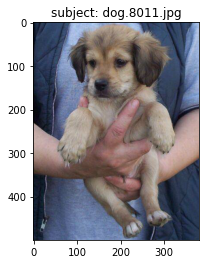

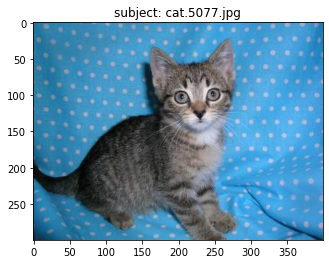

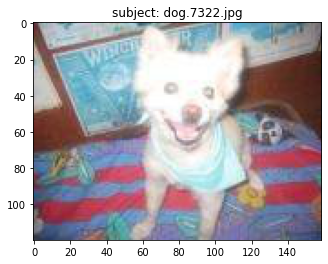

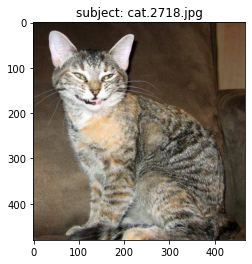

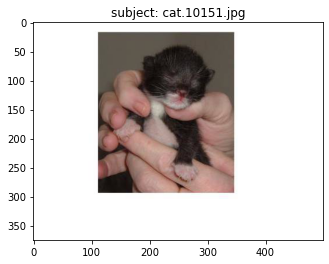

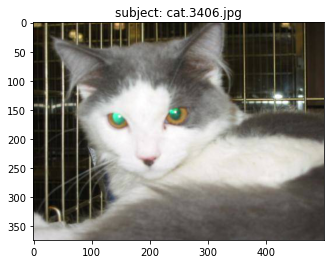

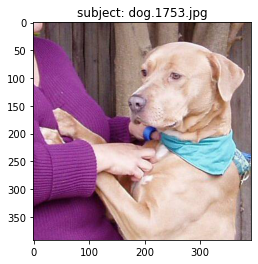

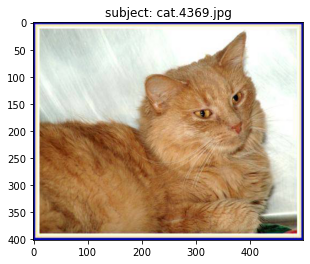

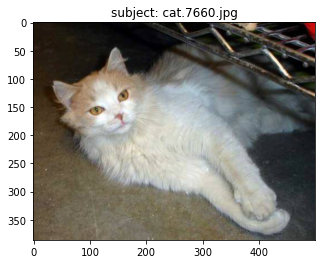

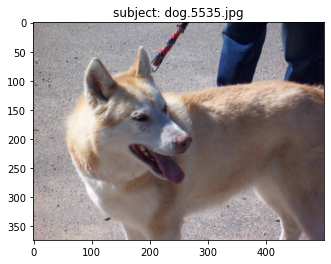

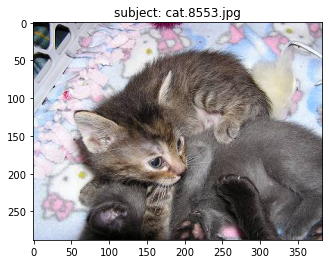

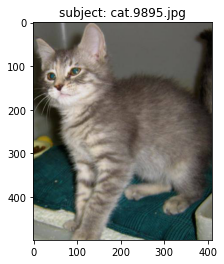

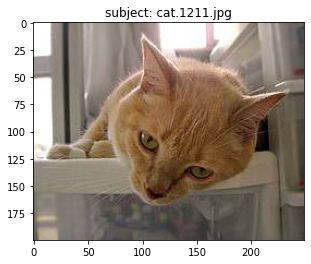

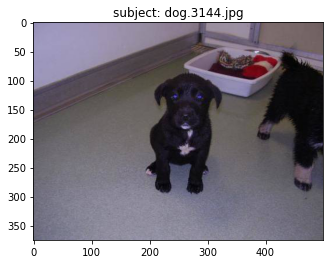

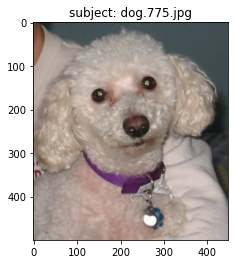

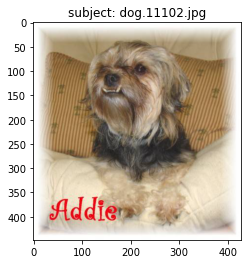

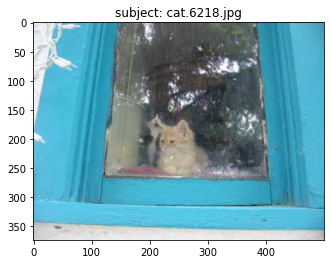

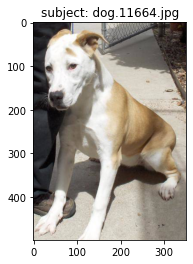

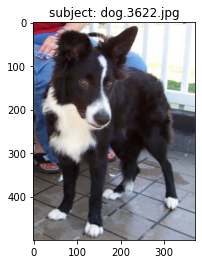

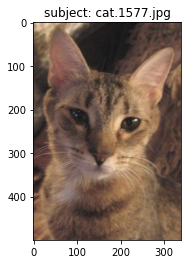

In [2]:
path_subjects = "../DATA/dogs-vs-cats/dataset"
count=0
for f_name in os.listdir(path_subjects):
    if(count<20):
        img = Image.open(path_subjects + '/' + f_name)
        plt.imshow(img, vmin=0, vmax=255)
        plt.title('subject: ' + str(f_name))
        plt.show()
        count+=1


In [3]:
experiment_rootdir = './CNN-results-simple/'
weights_path = './CNN-results-simple/weights.h5'
loss_img_name = './CNN-results-simple/loss.png'
accuracy_img_name = './CNN-results-simple/accuracy.png'
graph_loss_acc = './CNN-results-simple/loss-acc-comparation.png'
weights_file = Path(weights_path)

if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

In [4]:
# Randomize the initial network weights
random_seed = True

# Parameters that characterizes the images, size and image type
img_width=128
img_height=128
img_channels=3
img_mode='rgb'

# Parameters that configures the training process
batch_size=32
epochs = 20
lrate = 0.001
min_lrate = 0.00001

In [5]:
filenames=os.listdir("../DATA/dogs-vs-cats/dataset")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [6]:
def createSimpleNetwork(img_width,img_height,img_channels):
    model=Sequential()
    
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_width,img_height,img_channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    
    return model

In [7]:
def createNetworkVGG16(img_width,img_height,img_channels):
    #  dropout rate for FC layers
    dropout=0.5

    # CNN architecture

    input_image = Input(shape=(img_width,img_height,img_channels))
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Flatten()(x1)

    x=Dense(1024, activation='relu', kernel_constraint=maxnorm(3))(x1)
    x=Dropout(dropout)(x)

    out= Dense(2, activation='softmax')(x)

    model = Model(inputs = input_image, outputs = out);
    return model

In [8]:
def createNetworkResnet(img_width,img_height,img_channels):
    #  dropout rate for FC layers
    dropout=0.5

    # CNN architecture

    input_image = Input(shape=(32,32,3))
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(input_image)
    x1 = Conv2D(64, (3, 3),padding='same', activation='relu')(x1)
    x1 = MaxPooling2D((2, 2))(x1)

    x2 = Conv2D(128, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(128, (3, 3),padding='same')(x2)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(256, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(256, (3, 3),padding='same', activation='relu')(x2)
    x3 = Conv2D(256, (3, 3),padding='same')(x3)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(512, (3, 3),padding='same', activation='relu')(x2)
    x3 = Conv2D(512, (3, 3),padding='same')(x3)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)
    x2 = Conv2D(512, (3, 3),padding='same', activation='relu')(x1)
    x3 = Conv2D(512, (3, 3),padding='same', activation='relu')(x2)
    x3 = Conv2D(512, (3, 3),padding='same')(x3)

    x4 = Add()([x3,x2])
    x1 = Activation('relu')(x4)

    x1 = MaxPooling2D((2, 2))(x1)

    x1 = Flatten()(x1)
    x=Dense(1024, activation='relu', kernel_constraint=maxnorm(3))(x1)
    x=Dropout(dropout)(x)

    out= Dense(2, activation='softmax')(x)

    model = Model(inputs = input_image, outputs = out);
    
    return model

In [9]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})

train_df ,validate_df = train_test_split(df,test_size=0.20,random_state=1, shuffle=True)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df ,test_df = train_test_split(train_df,test_size=0.25,random_state=1, shuffle=True)
test_df = test_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
total_test=test_df.shape[0]

In [13]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

#Using ImageGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "../DATA/dogs-vs-cats/dataset/",
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../DATA/dogs-vs-cats/dataset/", 
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
    )

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [14]:
def trainModel(model):
    
    #probar otro compiler con otro optimizer en función del modelo que entrenemos
    #sdg = SGD(lr=lrate, momentum=0.9, decay=1e-6, nesterov=True)
    #adam = Adam(learning_rate=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #rmsprop = RMSprop(learning_rate=lrate, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False)
    model.compile(loss='categorical_crossentropy', optimizer= 'rmsprop' ,metrics=['accuracy'])
    print(model.summary())
    
    
    # Define training and validation steps taking into account the number of samples for each process and the batch size    
    STEPS_PER_EPOCH_TRAINING =  int(round(total_train//batch_size))
    STEPS_PER_EPOCH_VALIDATION = int(round(total_validate//batch_size))
    
    # Fit the model by using the fit generator
    earlystop = EarlyStopping(monitor='val_loss', patience = 10)
    learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 5,verbose = 1,factor = 0.5, min_lr = min_lrate)
    
    history = model.fit_generator(
        train_generator, 
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        callbacks=[earlystop,learning_rate_reduction]
    )
    return history

In [ ]:
simpleModel = createSimpleNetwork(img_width,img_height,img_channels)
#vggModel = createNetworkVGG16(img_width,img_height,img_channels)
#resnetModel = createNetworkResnet(img_width,img_height,img_channels)
history = trainModel(simpleModel)
simpleModel.save_weights(weights_path)

2022-01-15 18:37:07.351627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/isabel.rodriguez/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

2022-01-15 18:37:07.764799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
468/468 [==============================] - 356s 759ms/step - loss: 0.8293 - accuracy: 0.6173 - val_loss: 1.1804 - val_accuracy: 0.5557
Epoch 2/20
468/468 [==============================] - 382s 816ms/step - loss: 0.5590 - accuracy: 0.7153 - val_loss: 0.6293 - val_accuracy: 0.6727
Epoch 3/20
468/468 [==============================] - 358s 765ms/step - loss: 0.4884 - accuracy: 0.7656 - val_loss: 0.5214 - val_accuracy: 0.7522
Epoch 4/20
468/468 [==============================] - 338s 721ms/step - loss: 0.4535 - accuracy: 0.7868 - val_loss: 0.4186 - val_accuracy: 0.8129
Epoch 5/20
468/468 [==============================] - 327s 699ms/step - loss: 0.4251 - accuracy: 0.8032 - val_loss: 0.4646 - val_accuracy: 0.7871
Epoch 6/20
468/468 [==============================] - 337s 720ms/step - loss: 0.3979 - accuracy: 0.8232 - val_loss: 1.3096 - val_accuracy: 0.5467
Epoch 7/20
468/468 [==============================] - 339s 724ms/step - loss: 0.3893 - accuracy: 0.8272 - val_loss: 1.0610 -

In [ ]:
test_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

test_generator = test_datagen.flow_from_dataframe(    
    test_df,
    "../DATA/dogs-vs-cats/dataset/",
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
   )

In [ ]:
# Create the model by using the getModel function
#simpleModel = createSimpleNetwork(img_width,img_height,img_channels)
#vggModel = createNetworkVGG16(img_width,img_height,img_channels)
#resnetModel = createNetworkResnet(img_width,img_height,img_channels)
# Load saved weights
try:
    simpleModel.load_weights(weights_path)
    print("Loaded model from {}".format(weights_path))
except:
    print("Impossible to find weight path. Returning untrained model")

# Compile model
#sgd = SGD(lr=initial_lr, momentum=0.9, decay=decay, nesterov=False)
#adam = Adam(learning_rate=initial_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#rmsprop = RMSprop(learning_rate=lrate, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False)
#simpleModel.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

# Get predictions using predict_generator function
STEPS_PER_EPOCH_TEST = int(round(total_test//batch_size))
predict = simpleModel.predict_generator(test_generator, steps=STEPS_PER_EPOCH_TEST)

In [ ]:
test_df['category_predicted'] = np.argmax(predict, axis=1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category_predicted'] = test_df['category_predicted'].replace(label_map)
test_df['category_predicted'] = test_df['category_predicted'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
sample_test = test_df.sample(21).reset_index(drop = True)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category_predicted']
    img = load_img("../DATA/dogs-vs-cats/dataset/"+filename, target_size=(img_width,img_height))
    plt.subplot(7, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
results={
    0:'cat',
    1:'dog'
}

im=Image.open("../DATA/dogs-vs-cats/dataset/"+"7078.jpg")
im=im.resize((img_width,img_height))
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=simpleModel.predict_classes([im])[0]
print(pred,results[pred])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()

In [ ]:
# Plot the accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# Plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend(['train acc', 'test acc','train loss', 'test loss'])
plt.grid()

plt.savefig(graph_loss_acc)

In [ ]:
cm = confusion_matrix(test_df['category'], test_df['category_predicted'], labels=["cat", "dog"])
fig, ax = plt.subplots()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, 2, rotation=45)
plt.yticks(tick_marks, 2, rotation=45)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, float('%.1f'%(cm[i, j])),
             horizontalalignment="center")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig_save_path = os.path.join(experiment_rootdir, "CM.png")
plt.savefig(fig_save_path)
plt.show()